# I. Setup for Data Preprocessing, Training, and Evaluation

## 1. Environment Setup and Data Loading

In [171]:
#Import library
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.metrics import classification_report, confusion_matrix
penguins = sns.load_dataset("penguins")

## 2. Helper Functions for Model Training and Visualization

### 2.1 Draw the label distribution in the dataset
- This function visualizes the distribution of labels in the dataset before and after splitting it into training and testing sets. It first plots the class distribution of the original dataset, followed by the distribution of labels in both the training and test sets. This helps in assessing whether the label distribution is balanced across all sets after splitting.

In [172]:
def plot_class_distribution(labels, title, ax):
    sns.countplot(x=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

def visualizeDataset(Y_original, Y_train, Y_test, size_train, size_test):
    figure, axes = plt.subplots(1, 3, figsize=(18, 5))
    plot_class_distribution(Y_original, "Original Dataset", axes[0])
    plot_class_distribution(Y_train, f"Training Set ({size_train}%)", axes[1])
    plot_class_distribution(Y_test, f"Test Set ({size_test}%)", axes[2])

    print(f"Visualize dataset {size_train}/{size_test}")
    plt.tight_layout()
    plt.show()

### 2.2 Splitting the Dataset, Encoding Features, and Training the Decision Tree Model

- This function performs the following steps:
    - Splits the dataset into training and testing sets based on a given ratio, ensuring stratified sampling to maintain label distribution.
    - Encodes the features using one-hot encoding to prepare the data for model training.
    - Trains a Decision Tree Classifier (`DecisionTreeClassifier`) on the encoded training data.
    - Predicts labels for the encoded testing data.

- The function returns:
    - The original training and testing datasets after splitting.
    - The encoded training and testing datasets.
    - The trained Decision Tree model.
    - The predicted labels for the testing dataset.

In [173]:
def trainData(X, Y, size_test):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y,
        test_size=size_test,
        random_state=42,
        shuffle=True,
        stratify=Y
    )
    Y_train = Y_train.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))
    Y_test = Y_test.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))

    clf = DecisionTreeClassifier(criterion='entropy',random_state=42)
    clf = clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)
    return X_train, X_test, Y_train, Y_test, clf, Y_predict

### 2.3 Visualizing a Decision Tree from a Trained Model

#### 2.3.1 Decision Tree: Iterative Dichotomiser 3 (ID3)

- **Entropy**
    - The expected value of self-information (entropy):
    
    $$
    Entropy = -\sum_{i}^{n} p_i \log_{2}(p_i)
    $$

    - The entropy function reaches its minimum value when one of the $p_i$ values equals 1, and reaches its maximum value when all $p_i$ values are equal. These properties make entropy a measure of the level of disorder or randomness in a system.

- **Information Gain of an Attribute A**
  
    - The information gain when classifying the dataset $D$ by attribute $A$ is calculated as:

    $$
    Gain(A) = Entropy(D) - Entropy_{A}(D)
    $$

    - At each node in the ID3 algorithm, the attribute selected is the one with the highest information gain among the remaining attributes.

#### 2.3.2 One-Hot Encoding

- **General Formula**

    - Suppose we have a categorical feature X  with n different values. Each value of X will be represented by a binary vector of length n. If $x_i$  is a value of X, then the One-Hot Encoding vector of $x_i$ is given by:

$$
v(x_i) = [0, 0, \dots, 1, \dots, 0]
$$  
    - Where:
        - The i-th position in the vector is 1, representing the value $x_i$ in the list of categorical values.
        - All other positions in the vector are 0.


- **One-Hot Encoding Process**
    - The process includes:
        1. Identifying all the categorical values in the dataset.
        2. Creating a binary vector for each categorical value with a length equal to the number of categorical values.
        3. Placing a 1 in the position corresponding to the categorical value and placing 0 in all other positions.

- **Example**
    - For the feature "Color" with values "Red", "Green", and "Blue", the encoded result will be:
        - "Red" → (1, 0, 0)
        - "Green" → (0, 1, 0)
        - "Blue" → (0, 0, 1)

#### 2.3.3 The role of function

- The `buildTree` and `drawTree` function is responsible for visualizing a trained decision tree. Specifically, it retrieves the feature names from the training dataset, exports the tree structure in the DOT format, converts it into an image, and then displays it. This function helps users easily observe and analyze how the model makes decisions based on the data.

In [174]:
def buildTree(clf, X_train, class_names):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=X_train.columns,
                    class_names=class_names['species'])
    return dot_data
    
    
def drawTree(dot_data, size_train, size_test):
    print(f"Decision tree with dataset {size_train}/{size_test}")
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))  

### 2.4 Draw Classification Report 
- The `classificationReport` function prints a classification report and displays the confusion matrix, including metrics such as accuracy, recall, and F1 score for each class to evaluate the performance of the classification model and display the training and testing ratios along with the class labels.

In [175]:
def classificationReport(Y_test, Y_predict, size_train, size_test):
    print(f"Classification Report ({size_train}/{size_test}):\n")
    print(classification_report(Y_test, Y_predict))

### 2.5 Draw Confusion Matrix 
- The `confusionMatrixReport` function calculates and visualizes the confusion matrix for a classification model. The function then creates a heatmap of the confusion matrix, helping to visualize the performance of the classification model.

In [176]:
def confusionMatrixReport(Y_test, Y_predict, clf, size_train, size_test):
    print(f"Confusion Matrix (Depth={clf.tree_.max_depth}, {size_train}/{size_test} split):\n")
    cm = confusion_matrix(Y_test, Y_predict)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title(f"Confusion Matrix ({size_train}/{size_test} Split)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

### 2.6 Draw Decision Tree with Varying Max Depth
- The `drawTreeWithDepth` function evaluates the performance of a decision tree classifier by testing different values for the `max_depth` parameter. It fits a decision tree for each value of `max_depth`, calculates the accuracy on the test set, and visualizes the decision tree. This allows for an assessment of how changing the depth of the tree affects the model's performance.

In [177]:
def drawTreeWithDepth(dot_data, depth):
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    print(f"Decision Tree (max_depth={depth})")
    display(Image(graph.create_png())) 

### 2.7 Draw Accuracy Table Varying Max Depths
- The `accuraciesReport` function is used to display a table showing the accuracy scores of a Decision Tree classifier for different `max_depth` values. The accuracies are presented in a tabular format, allowing easy comparison of how the performance changes with varying tree depths.


In [178]:
def accuraciesReport(accuracies, max_depth):
    results = pd.DataFrame({
        'max_depth': ['None'] + max_depth[1:],
        'Accuracy': accuracies
    })
    results = results.set_index("max_depth").T
    print(results.to_string())

### 2.8 Plotting Accuracy vs Max Depth for Decision Tree
- The `chartReport` function is used to plot a graph showing how the accuracy of a Decision Tree model changes with different `max_depth` values. The chart helps visualize the relationship between the tree depth and the model's performance.


In [179]:
def chartReport(accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(['None', 2, 3, 4, 5, 6, 7], accuracies, marker='o')

    for i, acc in enumerate(accuracies):
        plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

    plt.title('Decision Tree Accuracy vs Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

## 3. Data Preprocessing

In [180]:
class_names = {}

for col in penguins.columns:
    if penguins[col].dtype == 'object':
        class_names[col] = penguins[col].unique().tolist()

penguins_encoded = pd.get_dummies(penguins, dummy_na=True)

feature = [col for col in penguins_encoded.columns if not col.startswith('species_')]
species = [col for col in penguins_encoded.columns if col.startswith('species_')]
X = penguins_encoded[feature]
Y = penguins_encoded[species]

Y_original = Y.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))

# II. Preparing for datasets

## 1. 40/60 Data Split

### 1.1 Train data for 40/60 split

In [181]:
X_train_40_60, X_test_40_60, Y_train_40_60, Y_test_40_60, clf_40_60, Y_predict_40_60 = trainData(X, Y, 0.6)

### 1.2 Visualizing Class Distribution with 40/60 Data Split

Visualize dataset 40/60


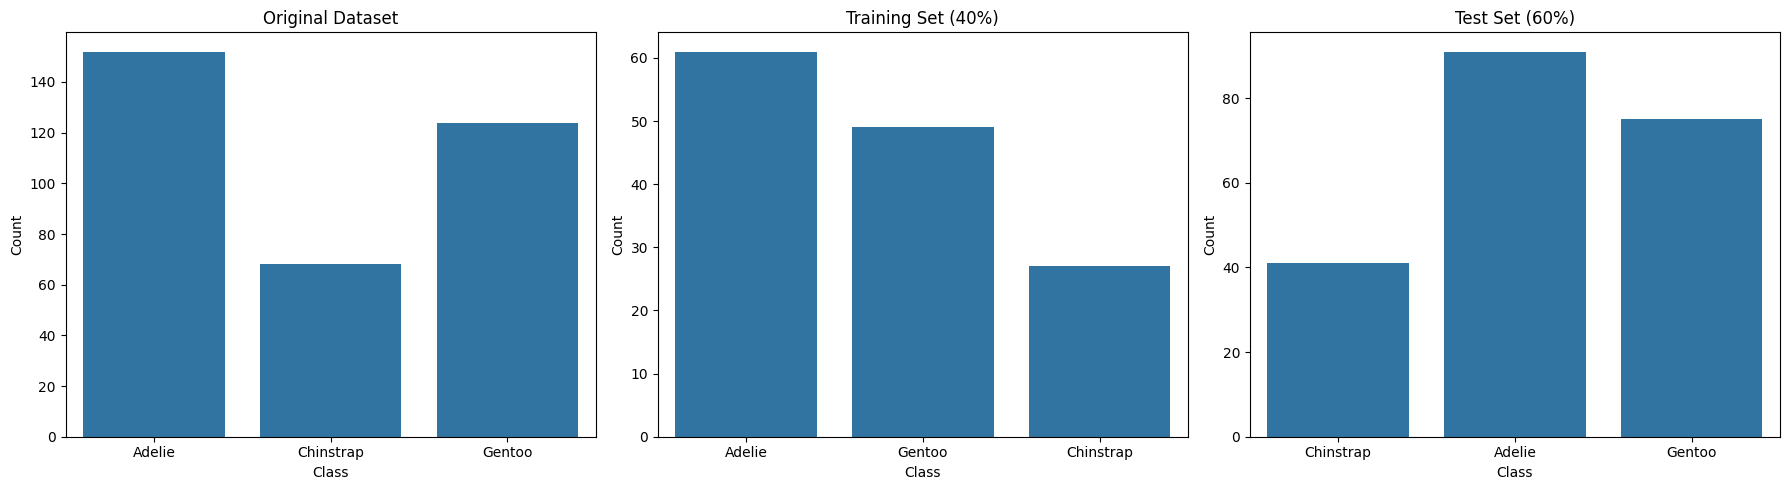

In [182]:
visualizeDataset(Y_original, Y_train_40_60, Y_test_40_60, 40, 60)

## 2. 60/40 Data Split

### 2.1 Train data for 60/40 split

In [183]:
# # train data 60/40
X_train_60_40, X_test_60_40, Y_train_60_40, Y_test_60_40, clf_60_40, Y_predict_60_40 = trainData(X, Y, 0.4)

### 2.2 Visualizing Class Distribution with 60/40 Data Split

Visualize dataset 60/40


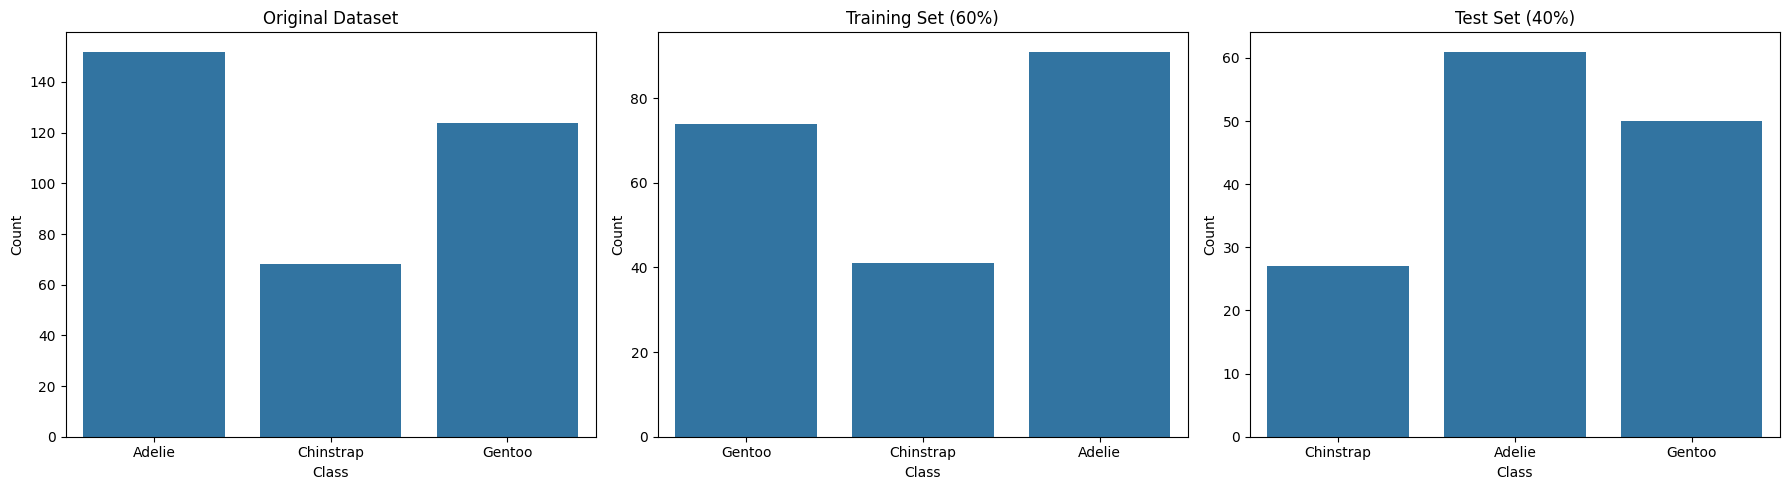

In [184]:
# Visualize dataset 60/40
visualizeDataset(Y_original, Y_train_60_40, Y_test_60_40, 60, 40)

## 3. 80/20 Data Split

### 3.1 Train data for 80/20 split

In [185]:
# Train data 80/20
X_train_80_20, X_test_80_20, Y_train_80_20, Y_test_80_20, clf_80_20, Y_predict_80_20 = trainData(X, Y, 0.2)

### 3.2 Visualizing Class Distribution with 80/20 Data Split

Visualize dataset 80/20


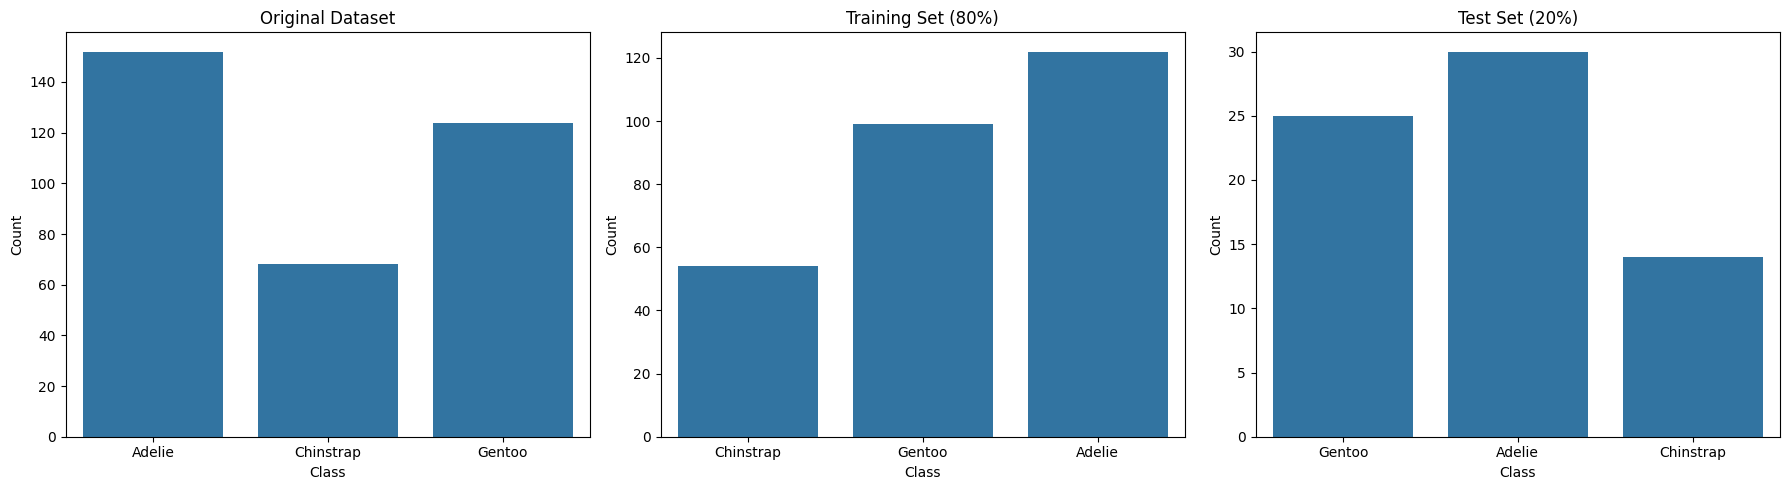

In [186]:
# Visualize dataset 80/20
visualizeDataset(Y_original, Y_train_80_20, Y_test_80_20, 80, 20)


## 4. 90/10 Data Split

### 4.1 Train data for 90/10 split

In [187]:
# Train data 90/10
X_train_90_10, X_test_90_10, Y_train_90_10, Y_test_90_10, clf_90_10, Y_predict_90_10 = trainData(X, Y, 0.1)

### 4.2 Visualizing Class Distribution with 90/10 Data Split

Visualize dataset 90/10


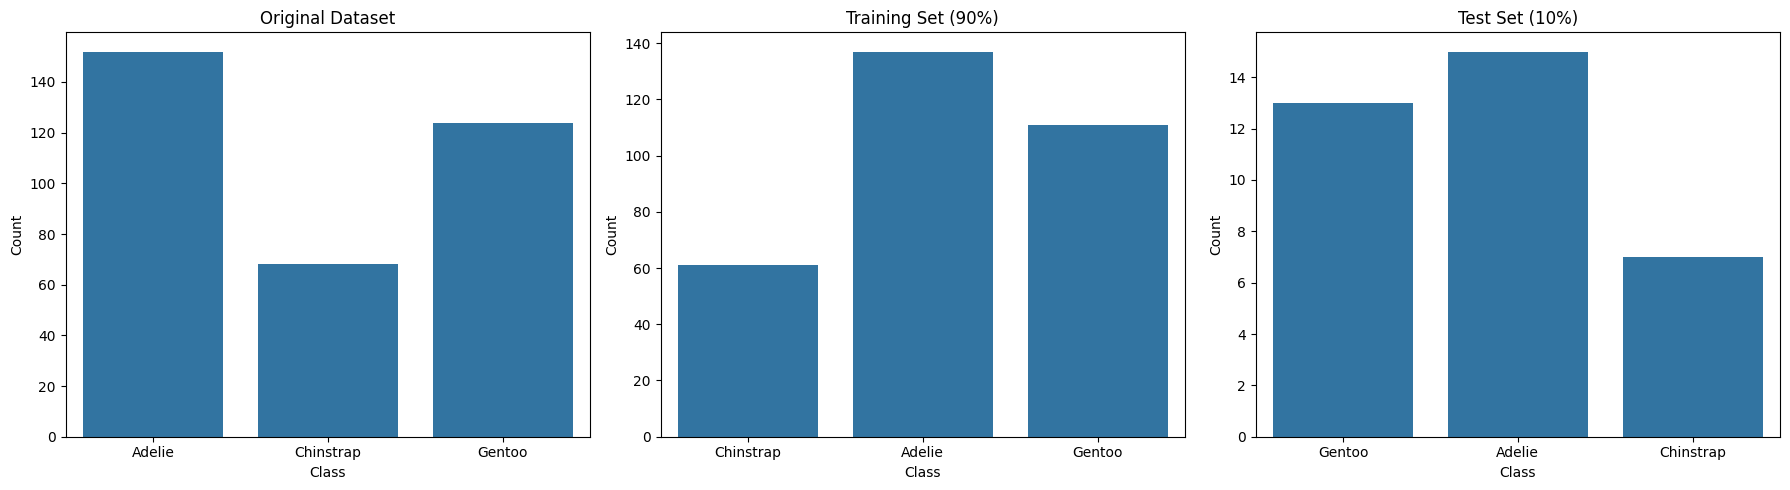

In [188]:
# Visualize dataset 90/10
visualizeDataset(Y_original, Y_train_90_10, Y_test_90_10, 90, 10)


# III. Building the decision tree classifiers

## 1. 40/60 Data Split

### 1.1 Visualizing Decision Tree for 40/60 Data Split

Decision tree with dataset 40/60


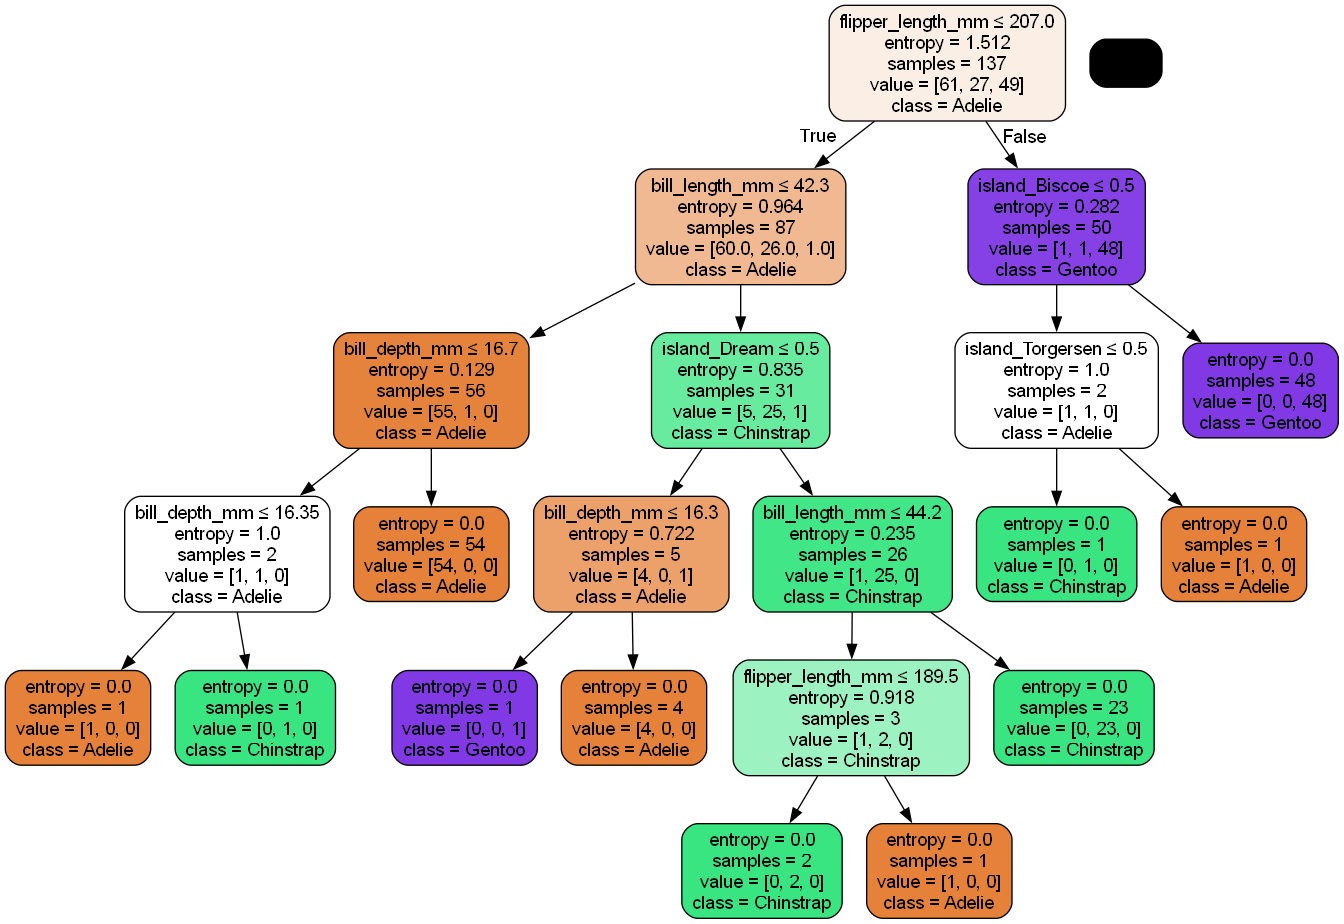

In [189]:
#Decision tree 40/60
dot_data = buildTree(clf_40_60, X_train_40_60, class_names)
drawTree(dot_data, 40, 60)

### 1.2 Classification Report Tree for 40/60 Data Split

In [190]:
classificationReport(Y_test_40_60, Y_predict_40_60, 40, 60)

Classification Report (40/60):

              precision    recall  f1-score   support

      Adelie       0.98      0.95      0.96        91
   Chinstrap       0.89      0.98      0.93        41
      Gentoo       1.00      0.99      0.99        75

    accuracy                           0.97       207
   macro avg       0.96      0.97      0.96       207
weighted avg       0.97      0.97      0.97       207



### 1.3 Confusion Matrix for 40/60 Data Split

Confusion Matrix (Depth=5, 40/60 split):



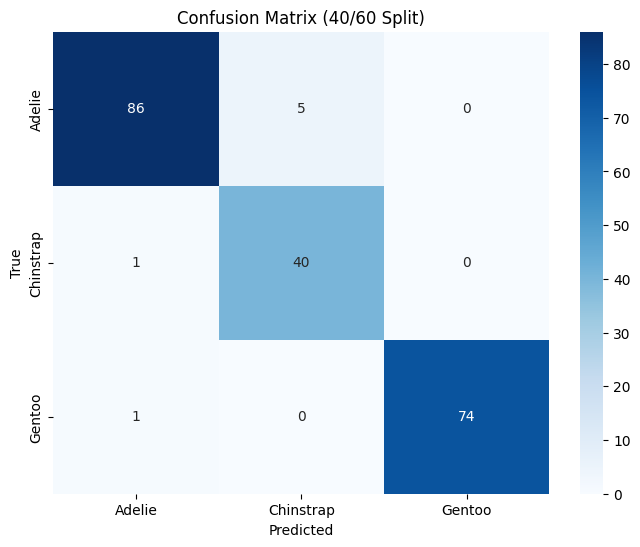

In [191]:
confusionMatrixReport(Y_test_40_60, Y_predict_40_60, clf_40_60, 40, 60)

## 2. 60/40 data split

### 2.1 Visualizing Decision Tree for 60/40 Data Split

Decision tree with dataset 60/40


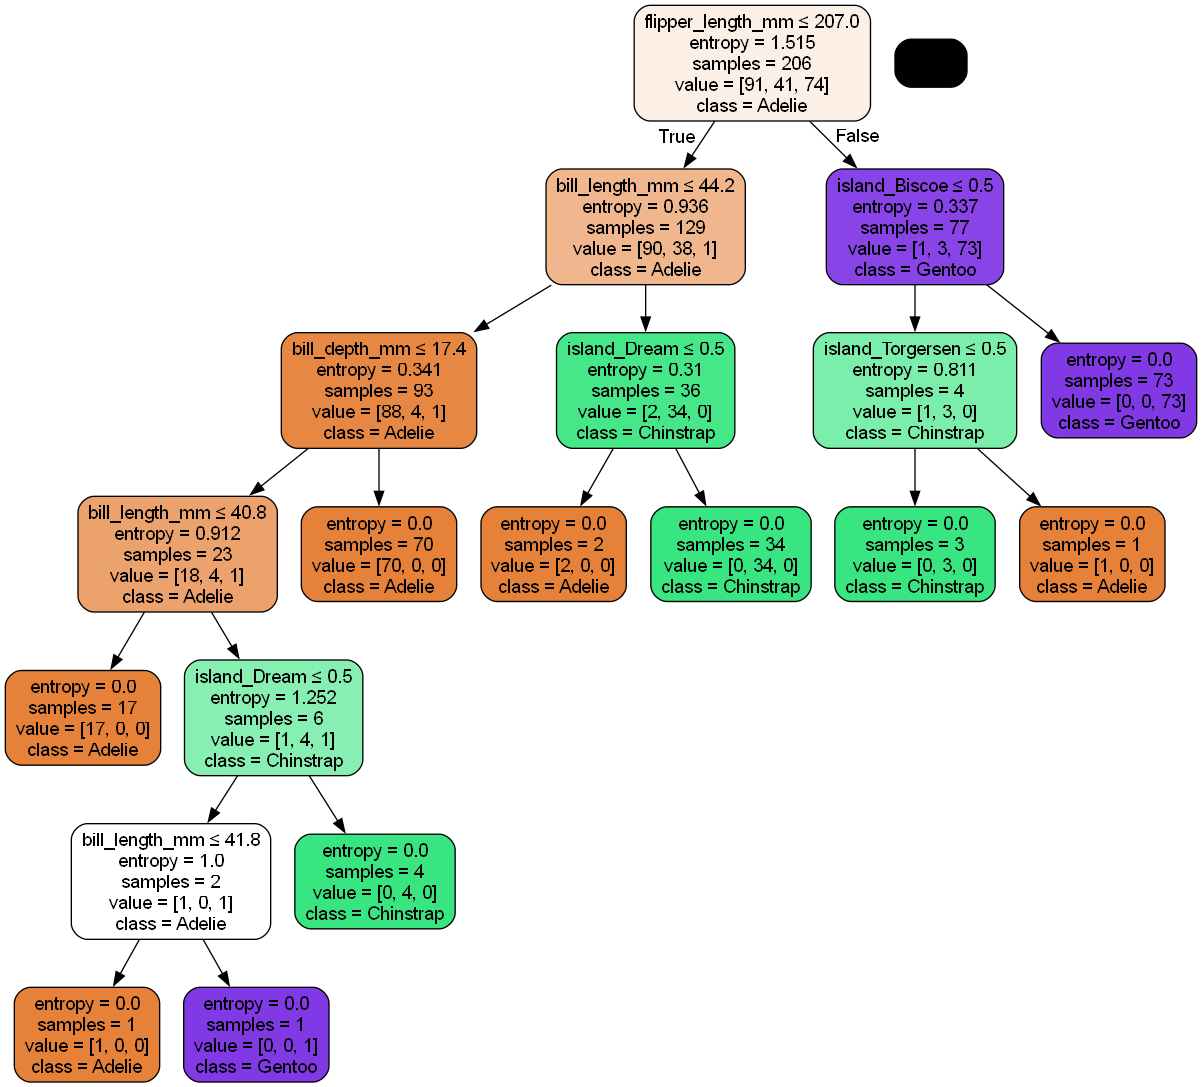

In [192]:
#Decision tree 60/40
dot_data = buildTree(clf_60_40, X_train_60_40, class_names)
drawTree(dot_data, 60, 40)

### 2.2 Classification Report for 60/40 Data Split

In [193]:
classificationReport(Y_test_60_40, Y_predict_60_40, 60, 40)

Classification Report (60/40):

              precision    recall  f1-score   support

      Adelie       0.94      0.98      0.96        61
   Chinstrap       0.96      0.96      0.96        27
      Gentoo       1.00      0.94      0.97        50

    accuracy                           0.96       138
   macro avg       0.97      0.96      0.96       138
weighted avg       0.97      0.96      0.96       138



### 2.3 Confusion Matrix for 60/40 Data Split

Confusion Matrix (Depth=6, 60/40 split):



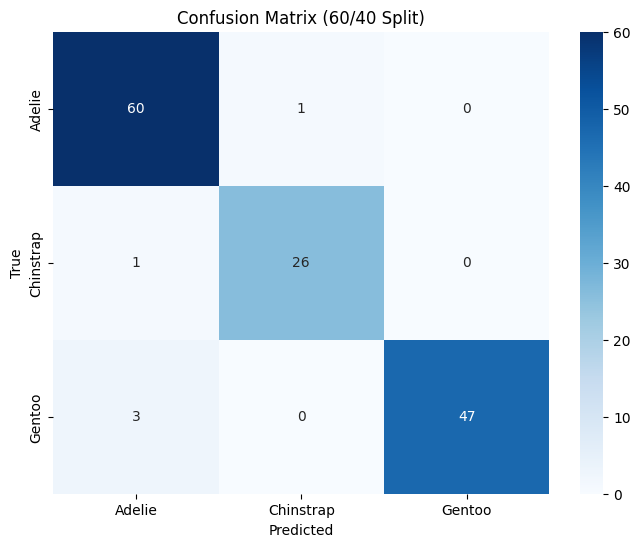

In [194]:
confusionMatrixReport(Y_test_60_40, Y_predict_60_40, clf_60_40, 60, 40)

## 3. 80/20 Data Split

### 3.1 Visualizing Decision Tree for 80/20 Data Split

Decision tree with dataset 80/20


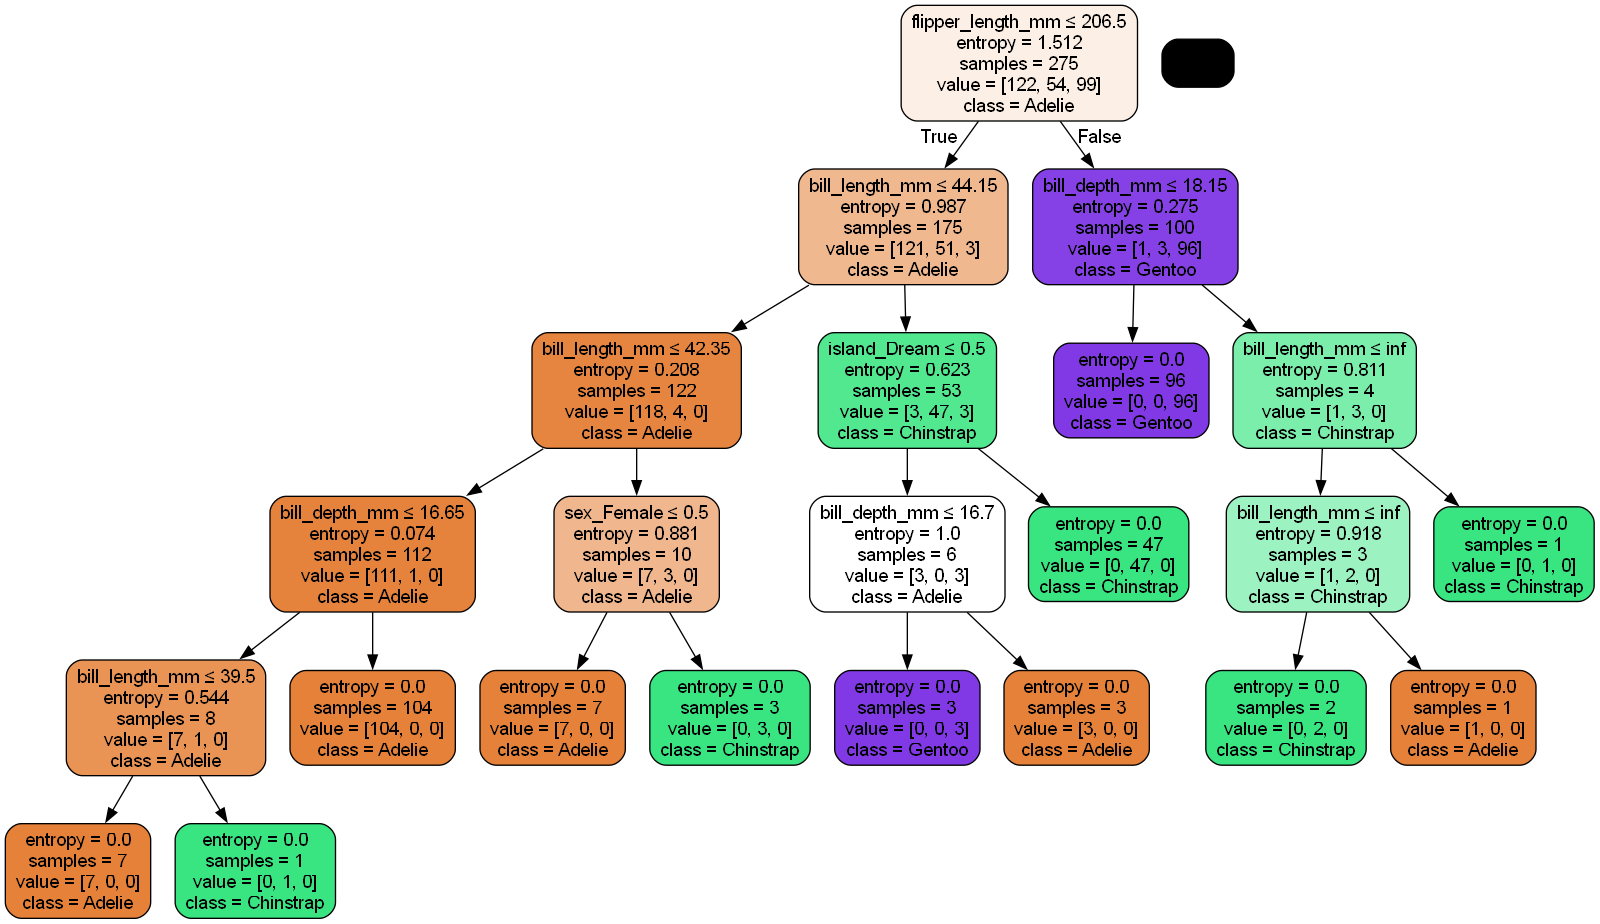

In [195]:
#Decision tree 80/20
dot_data = buildTree(clf_80_20, X_train_80_20, class_names)
drawTree(dot_data, 80, 20)

### 3.2 Classification Report for 80/20 Data Split

In [196]:
classificationReport(Y_test_80_20, Y_predict_80_20, 80, 20)

Classification Report (80/20):

              precision    recall  f1-score   support

      Adelie       1.00      0.93      0.97        30
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.97        69
   macro avg       0.96      0.98      0.97        69
weighted avg       0.97      0.97      0.97        69



### 3.3 Confusion Matrix for 80/20 Data Split

Confusion Matrix (Depth=5, 80/20 split):



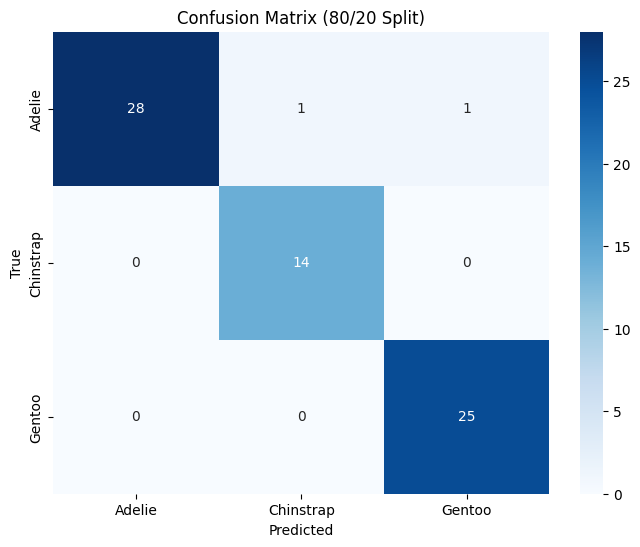

In [197]:
confusionMatrixReport(Y_test_80_20, Y_predict_80_20, clf_80_20, 80, 20)

## 4. 90/10 Data Split

### 4.1 Visualizing Decision Tree for 90/10 Data Split

Decision tree with dataset 90/10


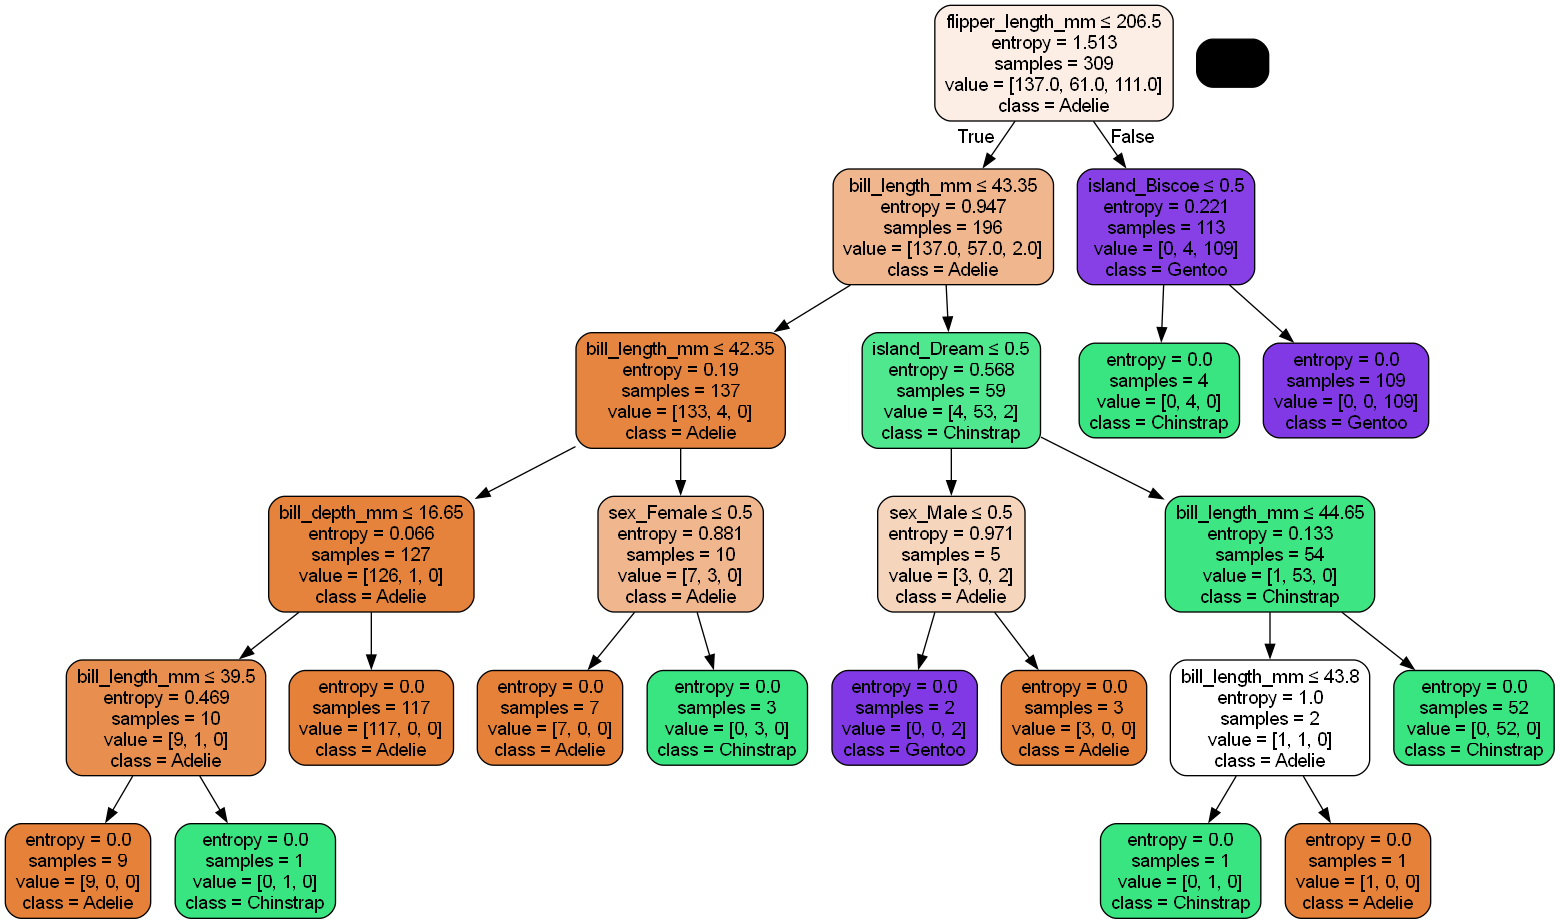

In [198]:
#Decision tree 90/10
dot_data = buildTree(clf_90_10, X_train_90_10, class_names)
drawTree(dot_data, 90, 10)

### 4.2 Classification Report for 90/10 Data Split

In [199]:
classificationReport(Y_test_90_10, Y_predict_90_10, 90, 10)

Classification Report (90/10):

              precision    recall  f1-score   support

      Adelie       1.00      0.87      0.93        15
   Chinstrap       0.78      1.00      0.88         7
      Gentoo       1.00      1.00      1.00        13

    accuracy                           0.94        35
   macro avg       0.93      0.96      0.93        35
weighted avg       0.96      0.94      0.94        35



### 4.3 Confusion Matrix for 90/10 Data Split

Confusion Matrix (Depth=5, 90/10 split):



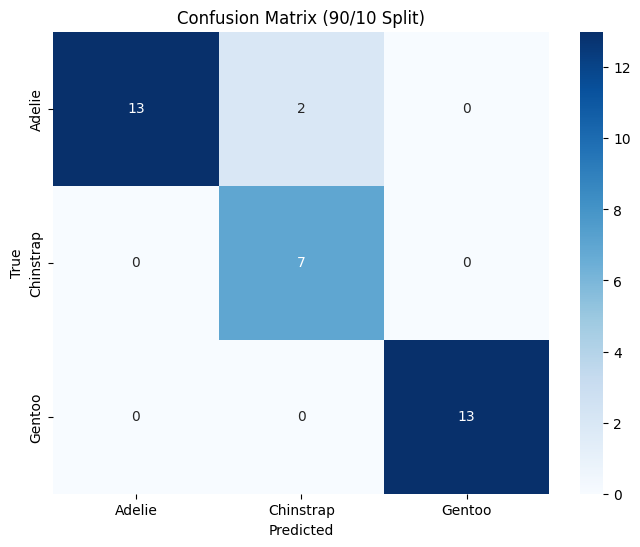

In [200]:
confusionMatrixReport(Y_test_90_10, Y_predict_90_10, clf_90_10, 90, 10)

# IV. The depth and accuracy of a decision tree

## 1. Prepare dataset 80/20 for each depth

In [201]:
#Prepare dataset 80/20 for each depth
max_depth = [None, 2, 3, 4, 5, 6, 7]
accuracies = []
trees = {}

for depth in max_depth:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=42)
    clf.fit(X_train_80_20, Y_train_80_20)
    Y_predict = clf.predict(X_test_80_20)
    accuracies.append(metrics.accuracy_score(Y_test_80_20, Y_predict))
    trees[depth] = clf

## 2. Visualizing Max Depth with 80/20 Data Split in Decision Tree

Decision Tree (max_depth=None)


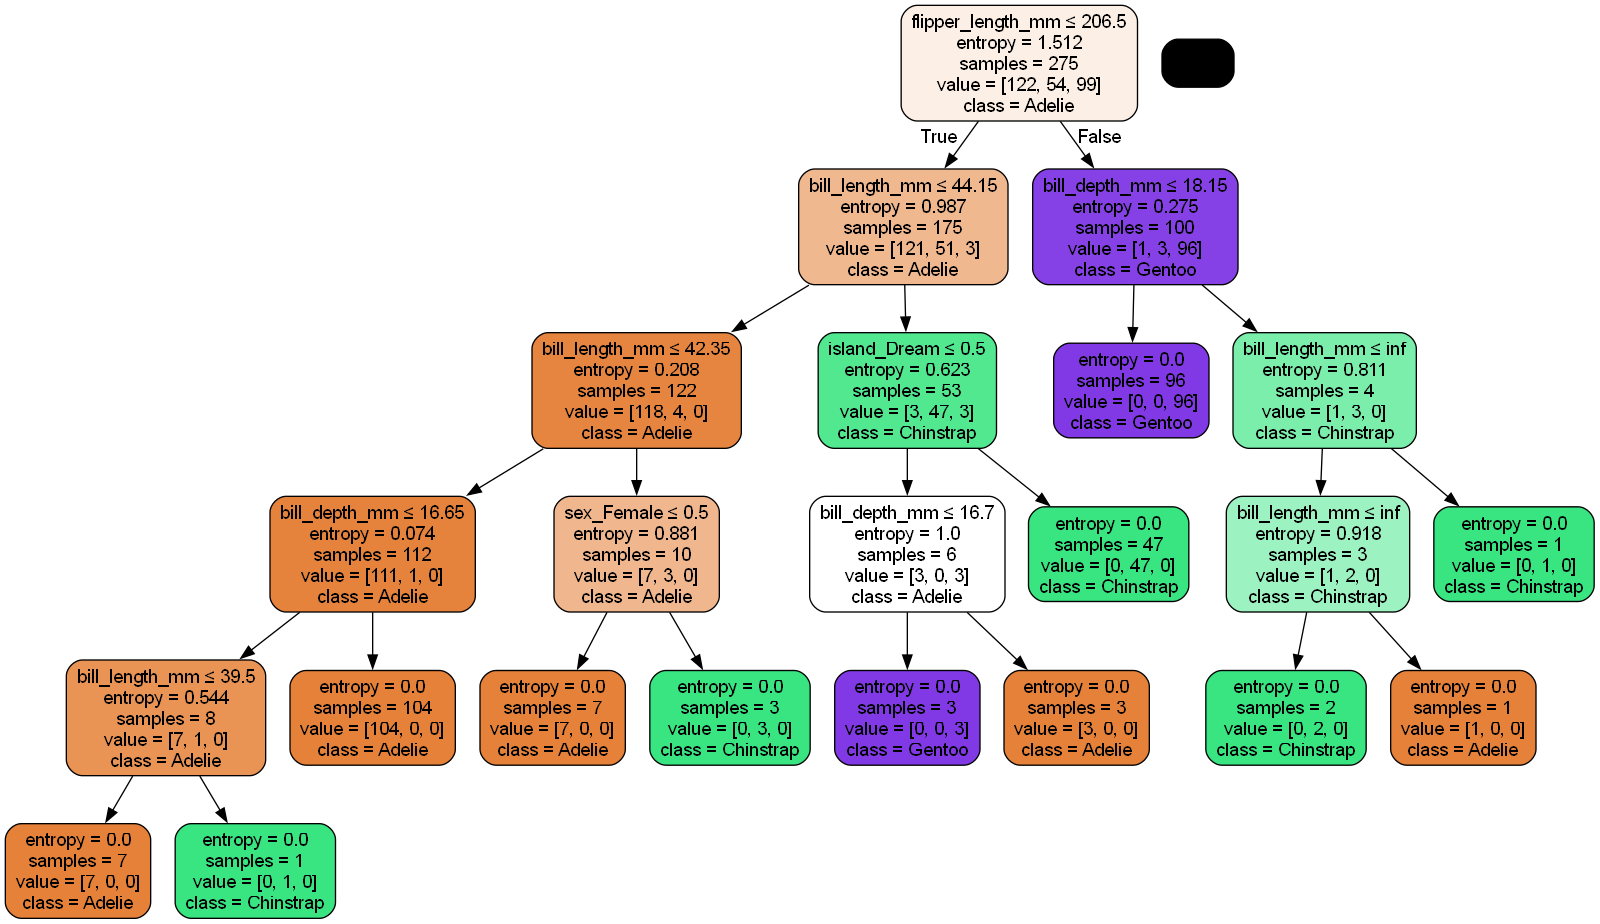

Decision Tree (max_depth=2)


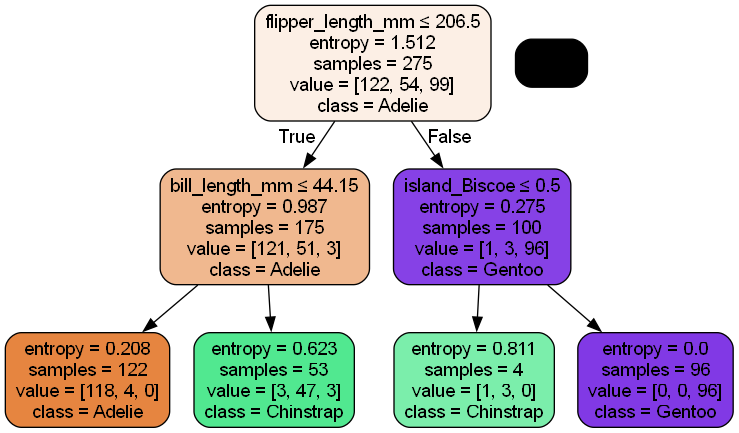

Decision Tree (max_depth=3)


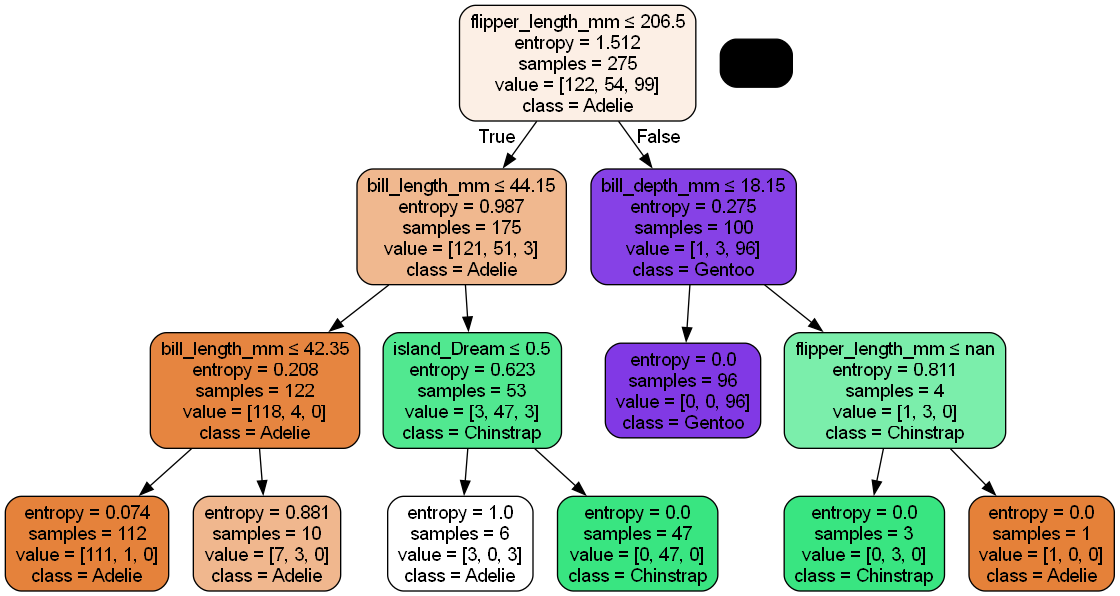

Decision Tree (max_depth=4)


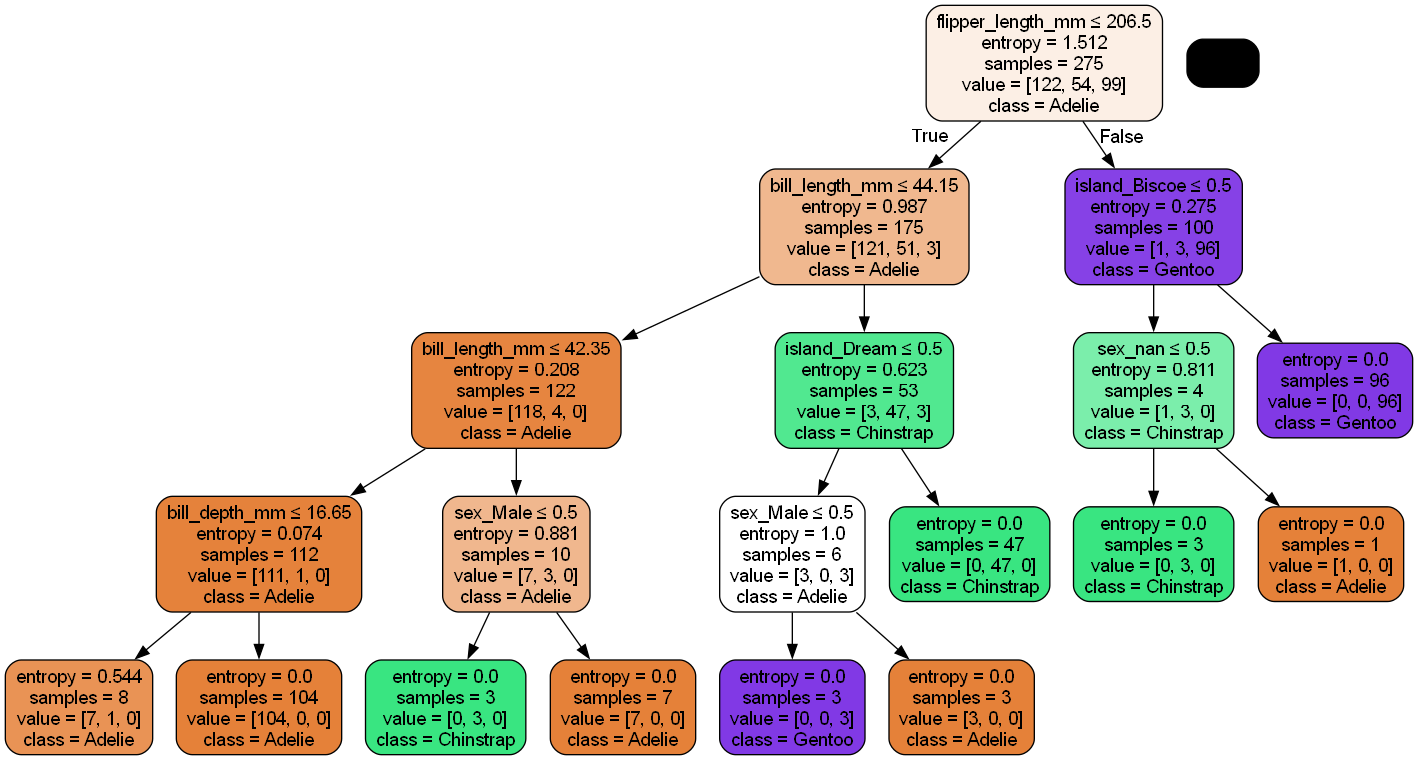

Decision Tree (max_depth=5)


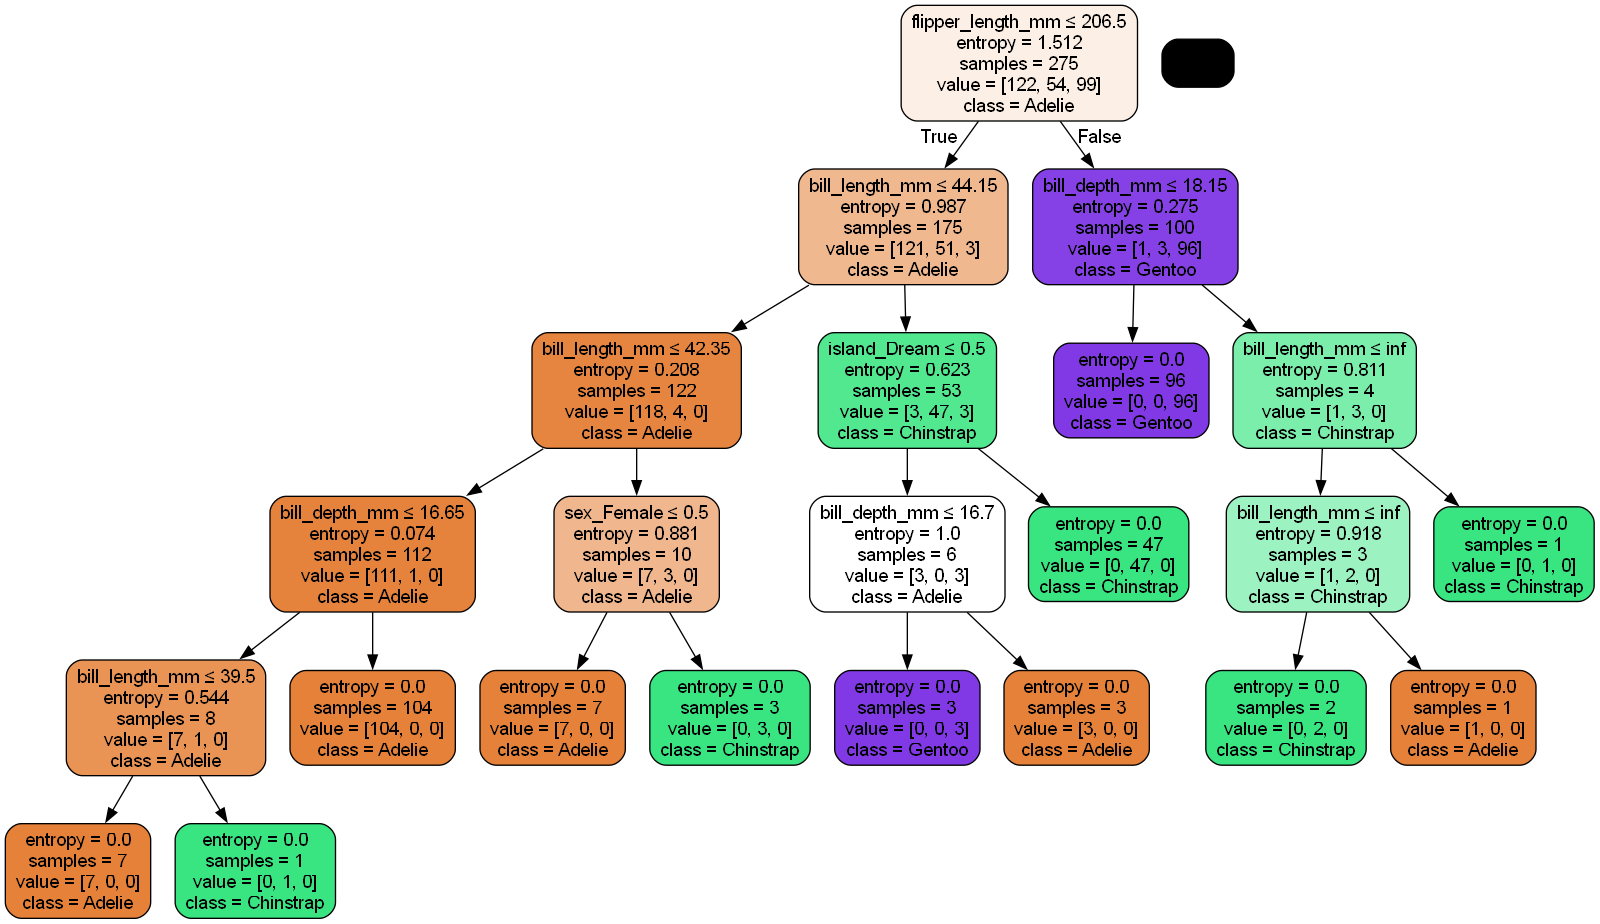

Decision Tree (max_depth=6)


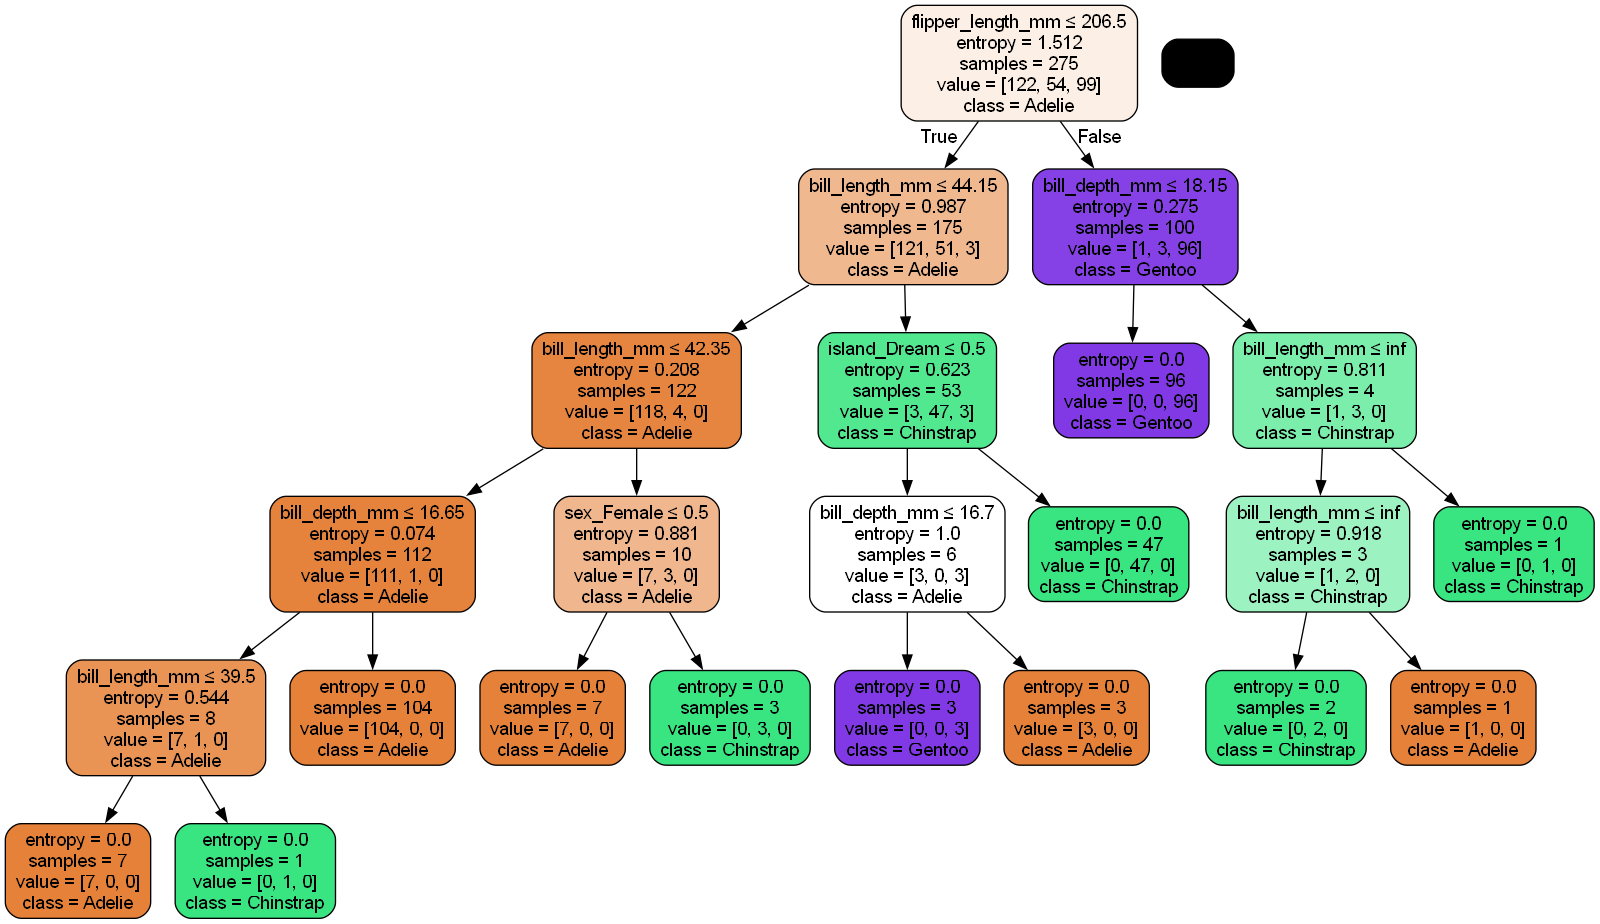

Decision Tree (max_depth=7)


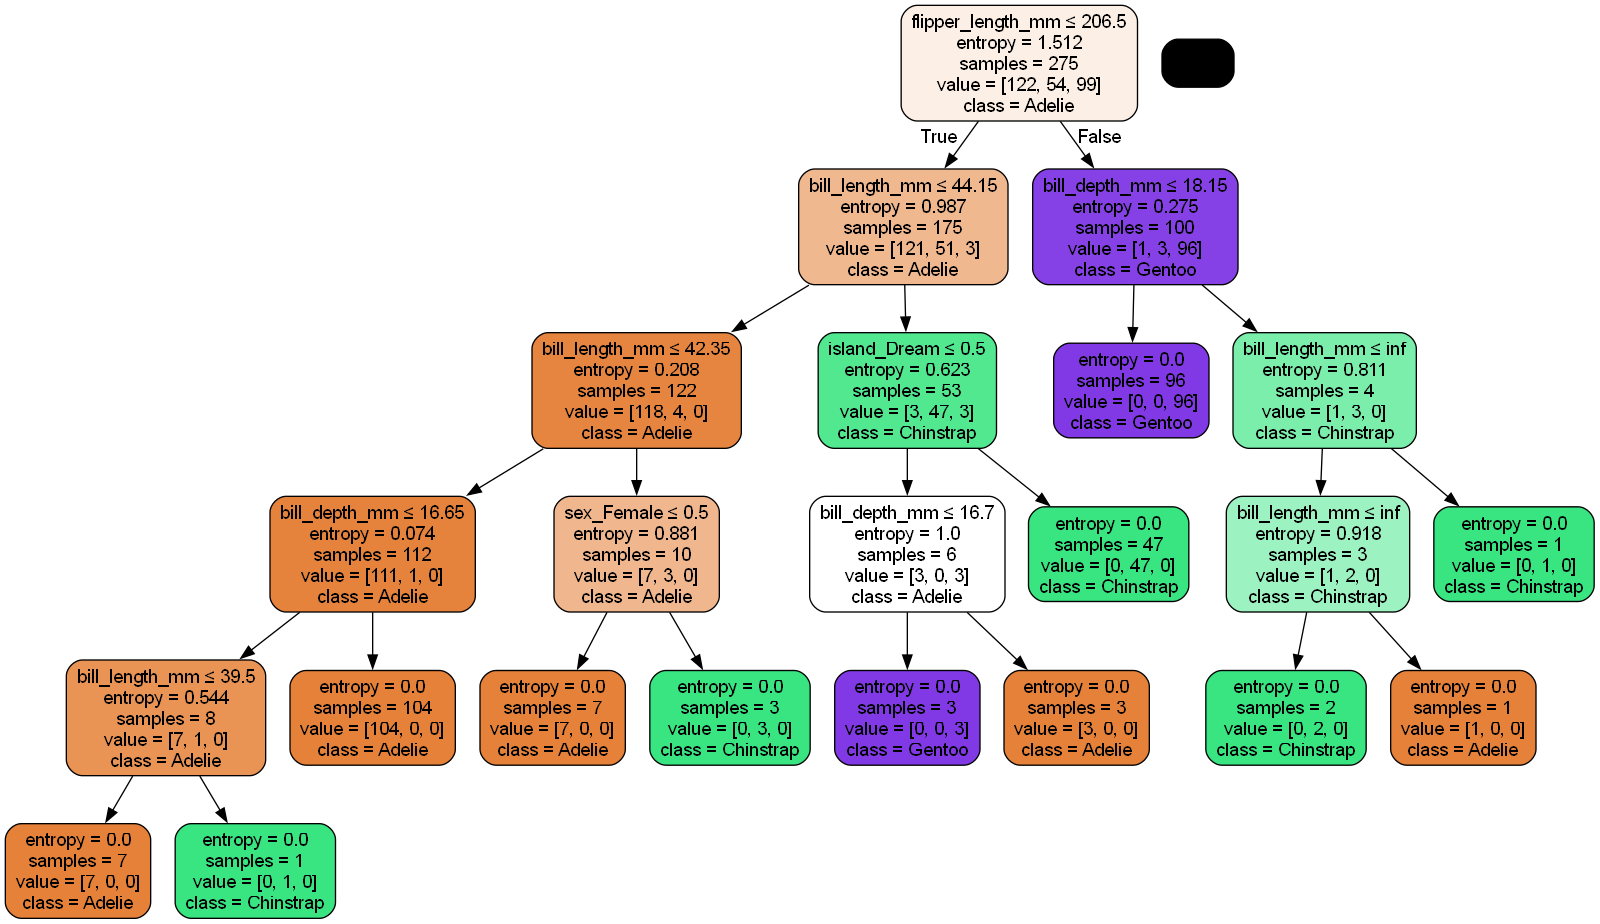

In [202]:
#Decision tree 80/20
for depth in max_depth:
    dot_data = buildTree(trees[depth], X_train_80_20, class_names)
    drawTreeWithDepth(dot_data, depth)


## 3. Accuracy Table for Varying Max Depths

In [203]:
accuraciesReport(accuracies, max_depth)

max_depth      None         2         3         4         5         6         7
Accuracy   0.971014  0.942029  0.927536  0.971014  0.971014  0.971014  0.971014


## 4. Accuracy Chart for Varying Max Depths

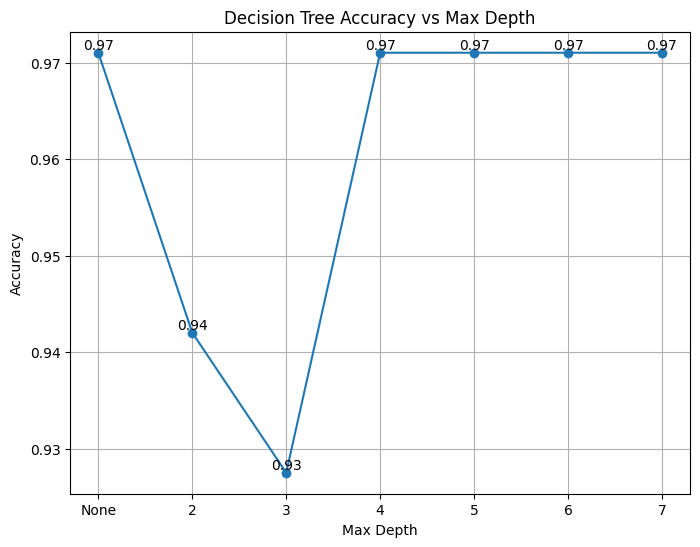

In [204]:
chartReport(accuracies)